<a href="https://colab.research.google.com/github/narendra974/insidedeeplearning/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

import requests, zipfile, io
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm


def moveTo(obj, device):
  if isinstance(obj, list):
    return [moveTo(x, device) for x in obj]
  elif isinstance(obj, tuple):
    return tuple(moveTo(list(obj), device))
  elif isinstance(obj, set):
    return set(moveTo(list(obj), device))
  elif isinstance(obj, dict):
    to_ret = dect()
    for key, value in obj.items():
      to_ret[moveTo(key, device)] = moveTo(value,device)
  elif hasattr(obj,"to"):
    return obj.to(device)
  else:
    return object


def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs. 
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary. 
    desc -- a description to use for the progress bar.     
    """
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.

        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch


def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, lr=0.001):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
        
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode
        
        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )
        
        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")
                    
    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)


def prediction(model, img):
  with torch.no_grad():
    w, h = img.shape
    if not isinstance(img, torch.Tensor):
      img = torch.tensor(img)
    x = img.reshape(1, -1, w, h)
    logits = model(x)
    y_hat = F.softmax(logits, dim=1)
    return y_hat.numpy().flatten()

In [5]:
name_language_data = {}

import unicodedata
import string

all_letters = string.ascii_letters + ".,;"
n_letters = len(all_letters)
alphabet = { }
for i in range(n_letters):
  alphabet[all_letters[i]] = i

def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  ) 

for zip_path in z.namelist():
  if "data/names/" in zip_path and zip_path.endswith(".txt"):
    lang = zip_path[len("data/names/"):-len("txt")]
    with z.open(zip_path) as myfile:
      lang_names = [unicodeToAscii(line).lower() for line in str(myfile.read(), encoding = 'utf-8').strip().split("\n")]
    name_language_data[lang] = lang_names
    print(lang, ":", len(lang_names))

Arabic. : 2000
Chinese. : 268
Czech. : 519
Dutch. : 297
English. : 3668
French. : 277
German. : 724
Greek. : 203
Irish. : 232
Italian. : 709
Japanese. : 991
Korean. : 94
Polish. : 139
Portuguese. : 74
Russian. : 9408
Scottish. : 100
Spanish. : 298
Vietnamese. : 73


In [6]:
from torch.utils.data import Dataset, DataLoader
import torch

class LanguageNameDataset(Dataset):
  
  def __init__(self, lang_name_dict, vocabulary):
    self.label_names = [x for x in lang_name_dict.keys()]
    self.data = []
    self.labels = []
    self.vocabulary = vocabulary
    for y, language in enumerate(self.label_names):
      for sample in lang_name_dict[language]:
        self.data.append(sample)
        self.labels.append(y)

  def __len__(self):
    return len(self.data)

  def string2InputVec(self, input_string):
    T = len(input_string)
    name_vec = torch.zeros((T), dtype=torch.long)
    for pos, character in enumerate(input_string):
      name_vec[pos] = self.vocabulary[character]
    return name_vec
  
  def __getitem__(self, idx):
    name = self.data[idx]
    label = self.labels[idx]
    label_vec = torch.tensor([label], dtype=torch.long)

    return self.string2InputVec(name), label

In [7]:
dataset = LanguageNameDataset(name_language_data, alphabet)

train_data, test_data = torch.utils.data.random_split(dataset, (len(dataset)-300, 300))
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)


In [8]:
import torch.nn as nn

with torch.no_grad():
  input_sequence = torch.tensor([0, 1, 1, 0, 2], dtype=torch.long)
  embd = nn.Embedding(3, 2)  # 3 represents the vocab size in the example {0, 1, 2} represents vocabulary. 
  x_seq = embd(input_sequence)
  print(input_sequence.shape, x_seq.shape)
  print(x_seq)

torch.Size([5]) torch.Size([5, 2])
tensor([[-1.2000, -0.8113],
        [ 0.2798,  0.1530],
        [ 0.2798,  0.1530],
        [-1.2000, -0.8113],
        [ 1.2268,  0.6942]])


In [9]:
class LastTimeStep(nn.Module):
  def __init__(self, rnn_layers=1, bidirectional=False):
    super(LastTimeStep, self).__init__()
    self.rnn_layer = rnn_layers
    if bidirectional:
      self.num_directions = 2
    else :
      self.num_directions = 1

  def forward(self, input):
    rnn_output = input[0]
    last_step  = input[1]
    if type(last_step) == tuple :
      last_step = last_step[0]
    batch_size = last_step.shape[1]
    last_step = last_step.view(self.rnn_layer, self.num_directions, batch_size, -1)
    last_step = last_step[self.rnn_layer-1]
    last_step = last_step.permute(1, 0, 2)
    return last_step.reshape(batch_size, -1)


In [10]:
D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

first_rnn = nn.Sequential(
    nn.Embedding(vocab_size, D),
    nn.RNN(D, hidden_nodes, batch_first=True),
    LastTimeStep(),
    nn.Linear(hidden_nodes, classes)
)

In [11]:
from torch.nn.modules import loss
loss_func = nn.CrossEntropyLoss()
batch_one_train = train_simple_network(first_rnn, loss_func, train_loader, test_loader=test_loader, score_funcs={'Accuracy' : accuracy_score},  device=device, epochs=5)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/19774 [00:00<?, ?it/s]

Testing:   0%|          | 0/300 [00:00<?, ?it/s]

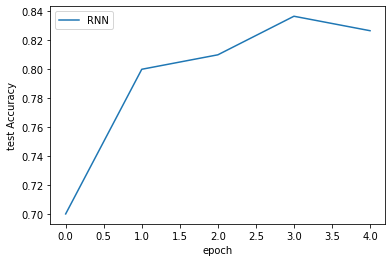

In [12]:
import seaborn as sns

sns.lineplot(x='epoch', y='test Accuracy', data=batch_one_train, label='RNN')

In [20]:
def pack_and_pad(batch):
  input_tensors = []
  labels = []
  lengths = []

  for x, y in batch:
    input_tensors.append(x)
    labels.append(y)
    lengths.append(x.shape[0])

  x_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=False)
  x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_padded, lengths, batch_first=False, enforce_sorted=False)
  y_batched = torch.as_tensor(labels, dtype=torch.long)
  return x_packed, y_batched

In [21]:
class EmbeddingPackable(nn.Module):

  def __init__(self, embd_layer):
    super(EmbeddingPackable, self).__init__()
    self.embd_layer = embd_layer

  def forward(self, input):
    if type(input) == torch.nn.utils.rnn.PackedSequence:
      sequences, lengths = torch.rnn.utils.rnn.pad_packed_sequence(input.cpu(), batch_first=True)
      sequences = self.embd_layer(sequences.to(input.data.device))
      return torch.nn.utils.rnn.pack_padded_sequence(sequences, lengths.cpu(), 
                                                     batch_first=True, enforce_sorted=False)
    else:
      return self.embd_layer(input)



In [25]:
B = 16
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, collate_fn=pack_and_pad)
test_loader = DataLoader(test_data, batch_size=B, shuffle=True, collate_fn=pack_and_pad)

In [26]:
rnn_packed = nn.Sequential(
    EmbeddingPackable(nn.Embedding(vocab_size, D)),
    nn.RNN(D, hidden_nodes, batch_first=True),
    LastTimeStep(),
    nn.Linear(hidden_nodes, classes)
)

In [27]:
batch_pack_train = train_simple_network(rnn_packed, loss_func, train_loader, test_loader=test_loader, score_funcs={'Accuracy' : accuracy_score},  device=device, epochs=20)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

TypeError: ignored